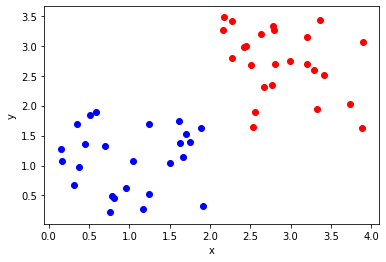

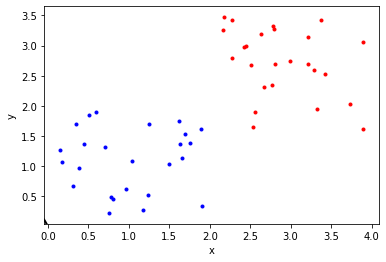

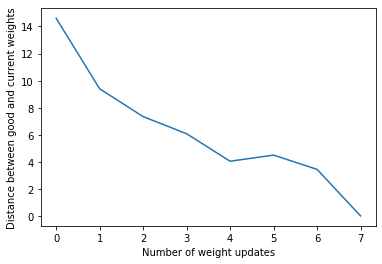

In [15]:
# Import packages
from lib2to3.pgen2.grammar import line
import numpy as np
import matplotlib.pyplot as plt
import time
from functools import partial
from ipywidgets import interact, RadioButtons, IntSlider, FloatLogSlider, Dropdown, BoundedFloatText
from numpy.linalg import norm
np.random.seed(17)
# Load data
data=np.loadtxt("./data/data01lab04.csv",delimiter=",")
class1=data[:,2]==1
class2=np.logical_not(class1)
# Graphics of the data
%matplotlib inline
plt.scatter(data[class1][:,0],data[class1][:,1], color="red")
plt.scatter(data[class2][:,0],data[class2][:,1], color="blue")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Perceptron definition
class Perceptron:
    def __init__(self,w,b):
        #
        # Ініціалізує перцептрон.
        # w -вектор вагів, розмірність (m, 1), де m -кількість змінних
        # b -число
        #
        self.w=w
        self.b=b
    # Метод повертає відповідь персептрона для одного прикладу
    # single_input -вектор прикладу розміру (m, 1).
    # Метод повертає 0 або 1     
    def forward_pass(self,single_input):
        result=0
        for i in range(0,len(self.w)):
            result+=self.w[i]*single_input[i]
        result+=self.b
        
        if result>0:
            return 1
        else:
            return 0
    # 
    # Метод повертає відповідь персептрону для набору прикладів
    # input_matrix -матриця прикладу розміру (n, m),n -кількість прикладів, m -кількість змінних
    # Повертає  вертикальний  вектор  розмірності  (n,  1)  з  відповідями персептрона
    # (елементы вектора -0 або 1 (false/true) )
    def vectorized_forward_pass(self,input_matrix):
        return input_matrix.dot(self.w) + self.b > 0
    #
    # Навчає персептрон (одна ітерація) на одному прикладі
    # example -вхідний вектор розмірності  (m, 1) 
    # y -правильна відповідь для нього (0 або 1 або boolean),
    # повертає розмір помилки, до зміни ваг (0 або 1)
    def train_on_single_example(self, example, y):
        error=y-self.forward_pass(example)
        self.w+=error*example
        self.b+=error
        return abs(error)
    #
    # Навчає персептрон
    # input_matrix -матриця входів розмірності (n, m),y -вектор правильних
    # відповідей розмірності (n, 1)max_steps -максимальна кількість кроків.
    def train_until_convergence(self, input_matrix, y, max_steps=1e4):
        i = 0
        errors = 1
        while errors and i < max_steps:
            i += 1
            errors = 0
            for example, answer in zip(input_matrix, y):
                example = example.reshape((example.size, 1))
                error = self.train_on_single_example(example, answer)
                errors += int(error)
                
# Створюємо персептрон з випадковими вагами та m виходами
def create_perceptron(m):
    w=np.random.random((m,1))
    return Perceptron(w,1)

# Візуалізація роботи персептрону
def plot_line(coefs):
    """малює розділяючу пряму, 
    coefs = (weights, bias), 
    де weights -масив формы (2, 1), 
    bias -число"""
    w, bias = coefs
    a, b = -w[0][0] / w[1][0], -bias / w[1][0]
    xx = np.linspace(*plt.xlim())
    line.set_data(xx, a*xx + b)

def step_by_step_weights(p, input_matrix, y, max_steps=1e3):
    i = 0
    errors = 1
    while errors and i < max_steps:
        i += 1
        errors = 0
        for example, answer in zip(input_matrix, y):
            example = example.reshape((example.size, 1))
            error = p.train_on_single_example(example, answer)
            errors += error
            if error:
                yield p.w, p.b
    for _ in range(20): yield p.w, p.b

%matplotlib inline
np.random.seed(17)
fig = plt.figure()
plt.scatter(data[class1][:,  0],  data[class1][:,  1],  color  =  "red", marker=".", label="Class1")
plt.scatter(data[class2][:,  0],  data[class2][:,  1],  color  =  "blue",  marker=".", label="Class2")
plt.xlabel("x")
plt.ylabel("y")
line, = plt.plot([], [], color="black", linewidth=2) 
from matplotlib.animation import FuncAnimation
perceptron_for_weights_line = create_perceptron(2)  
weights_ani = partial(step_by_step_weights,  p=perceptron_for_weights_line,  input_matrix=data[:,  :-1], y=data[:, -1][:,np.newaxis])  
ani   =   FuncAnimation(fig,   func=plot_line,   frames=weights_ani,   blit=False, interval=1000, repeat_delay=1000, repeat=True)
plt.show()

def step_by_step_errors(p, input_matrix, y, max_steps=1e3):
    """послідовно навчає персептрон на кожному рядку, на  кожному  етапі  запам'ятовує  кількість  неправильно  класифікованих прикладівповертає список із цих кількостей"""
    def count_errors():
        return np.abs(p.vectorized_forward_pass(input_matrix).astype(np.int) -y).sum()
    errors_list = [count_errors()]
    i = 0
    errors = 1
    while errors and i < max_steps:
        i += 1
        errors = 0
        for example, answer in zip(input_matrix, y):
            example = example.reshape((example.size, 1))
            error = p.train_on_single_example(example, answer)
            errors += error
        errors_list.append(count_errors())
        return errors_list

%matplotlib inline
np.random.seed(17)
perceptron_for_misclassification = create_perceptron(2)
errors_list = step_by_step_errors(perceptron_for_misclassification, input_matrix=data[:, :-1], y=data[:, -1][:,np.newaxis])
plt.plot(errors_list)
plt.ylabel("Number of errors")
plt.xlabel("Algorithm step number");

def get_vector(p):
    """повертає вектор із усіх вагів персептрона, включаючи зміщення (поріг)p-персептрон"""
    v = np.array(list(p.w.ravel()) + [p.b])
    return v

def step_by_step_distances(p, ideal, input_matrix, y, max_steps=1e3):
    """навчає персептрон та записує кожну зміну відстаней від поточних вагів до idealр -персептрон"""
    distances = [norm(get_vector(p) -ideal)]
    i = 0
    errors = 1
    while errors and i < max_steps:
        i += 1
        errors = 0
        for example, answer in zip(input_matrix, y):
            example = example.reshape((example.size, 1))
            error = p.train_on_single_example(example, answer)
            errors += error
        if errors:
            distances.append(norm(get_vector(p) -ideal))
    return distances

%matplotlib inline
np.random.seed(17)
init_weights = np.random.random_sample(3)
w,b = init_weights[:-1].reshape((2, 1)), init_weights[-1]
ideal_p = Perceptron(w.copy(), b.copy())
ideal_p.train_until_convergence(data[:, :-1], data[:, -1][:,np.newaxis])
ideal_weights = get_vector(ideal_p)
new_p = Perceptron(w.copy(), b.copy())
distances=  step_by_step_distances(new_p,  ideal_weights,  data[:,  :-1],  data[:, -1][:,np.newaxis])
plt.xlabel("Number of weight updates")
plt.ylabel("Distance between good and current weights")
plt.plot(distances);